In [2]:
from typing import Tuple

import cvxpy as cvx
import networkx as nx
import numpy as np
from graph import Graph

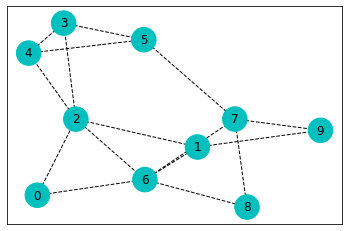

In [18]:
E = [(2, 0), (1, 2), (2, 3), (1, 6), (6,2), (2,4), (4,3),(4,5), (4,2), (5,3), (6,0), (7,5), (7,6),(7,8), (8,6), (1,9), (9,7)]


g = Graph(10, E)
g.draw()

In [19]:
def goemans_williamson(graph: nx.Graph) -> Tuple[np.ndarray, float, float]:
    """
    The Goemans-Williamson algorithm for solving the maxcut problem.
    Ref:
        Goemans, M.X. and Williamson, D.P., 1995. Improved approximation
        algorithms for maximum cut and satisfiability problems using
        semidefinite programming. Journal of the ACM (JACM), 42(6), 1115-1145
    Returns:
        np.ndarray: Graph coloring (+/-1 for each node)
        float:      The GW score for this cut.
        float:      The GW bound from the SDP relaxation
    """
    # Kudos: Originally implementation by Nick Rubin, with refactoring and
    # cleanup by Jonathon Ward and Gavin E. Crooks
    laplacian = np.array(0.25 * nx.laplacian_matrix(graph).todense())

    # Setup and solve the GW semidefinite programming problem
    psd_mat = cvx.Variable(laplacian.shape, PSD=True)
    obj = cvx.Maximize(cvx.trace(laplacian * psd_mat))
    constraints = [cvx.diag(psd_mat) == 1]  # unit norm
    prob = cvx.Problem(obj, constraints)
    prob.solve(solver=cvx.CVXOPT)

    evals, evects = np.linalg.eigh(psd_mat.value)
    sdp_vectors = evects.T[evals > float(1.0E-6)].T

    # Bound from the SDP relaxation
    bound = np.trace(laplacian @ psd_mat.value)

    random_vector = np.random.randn(sdp_vectors.shape[1])
    random_vector /= np.linalg.norm(random_vector)
    colors = np.sign([vec @ random_vector for vec in sdp_vectors])
    score = colors @ laplacian @ colors.T

    return colors, score, bound

In [20]:
laplacian = np.array(0.25 * nx.laplacian_matrix(g.G).todense())
colors, score, bound = goemans_williamson(g.G)
print(goemans_williamson(g.G))

scores = [goemans_williamson(g.G)[1] for n in range(100)]
print(min(scores), max(scores))

(array([ 1.,  1., -1.,  1.,  1., -1., -1.,  1., -1., -1.]), 13.0, 13.216755912906219)
10.0 13.0


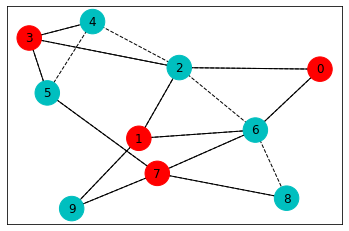

In [21]:
cut_edges = []
for edge in g.E:
    if colors[edge[0]] != colors[edge[1]]:
        cut_edges.append(edge)
g.draw(colors=['r' if bit == 1 else 'c' for bit in colors], cut_edges=cut_edges)